In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import DateOffset
import openpyxl as op
from tqdm.auto import tqdm
import plotly.graph_objs as go
import time
import plotly.express as px
import warnings
warnings.filterwarnings("ignore", message="No frequency information was")

instances = pd.read_csv("../instances/instances.csv", index_col=0).to_numpy().reshape(14)

In [2]:
# Cargar datos de real time prices
data_price = pd.read_csv("prices_15min.csv")
data_price['DateTime'] = pd.to_datetime(data_price['DateTime'])
data_price.index = data_price['DateTime']
data_price.drop(columns=['DateTime'], inplace=True)
data_price.columns = ["p"]
data_price['hour'] = data_price.index.floor('H')
data_price.head()

,p,hour
DateTime,,
2019-05-01 00:00:00,18.989333,2019-05-01 00:00:00
2019-05-01 00:15:00,17.593667,2019-05-01 00:00:00
2019-05-01 00:30:00,16.906667,2019-05-01 00:00:00
2019-05-01 00:45:00,15.866667,2019-05-01 00:00:00
2019-05-01 01:00:00,20.992667,2019-05-01 01:00:00


In [3]:
# Cargar datos de dayahead prices
data_dayahead = pd.read_csv("../15minute_data_newyork/nyiso_dayahead.csv", sep=";", decimal=",")
data_dayahead["DateTime"]=pd.to_datetime(data_dayahead["DateTime"])
data_dayahead.index = data_dayahead["DateTime"]
data_dayahead.drop(columns=['DateTime'], inplace=True)

data_dayahead["day_ahead_lbmp (avg) (nyiso)"].update(data_dayahead["day_ahead_lbmp (avg) (nyiso).1"])
data_dayahead["day_ahead_lbmp (avg) (nyiso)"].update(data_dayahead["day_ahead_lbmp (avg) (nyiso).2"])
data_dayahead.drop(columns=["day_ahead_lbmp (avg) (nyiso).1", "day_ahead_lbmp (avg) (nyiso).2"], inplace=True)
data_dayahead.columns = ['dayahead']
data_dayahead.head()

,dayahead
DateTime,
2019-05-01 00:00:00,17.933
2019-05-01 01:00:00,16.235
2019-05-01 02:00:00,14.399
2019-05-01 03:00:00,14.128
2019-05-01 04:00:00,14.147


In [4]:
def get_lags(data, col, m):
    for x in range(1, m+1):
        data[col+'_'+str(x)] = data[col].shift(x)

    return data

In [5]:
# Unir precios de energia dayahead con realtime
data_price = data_price.merge(data_dayahead, how="left", left_on='hour', right_index=True)
data_price.drop(columns=['hour'], inplace=True)
data_price['e'] = data_price['p']-data_price['dayahead']
#data_price = get_lags(data_price, 24)
data_price.head()

,p,dayahead,e
DateTime,,,
2019-05-01 00:00:00,18.989333,17.933,1.056333
2019-05-01 00:15:00,17.593667,17.933,-0.339333
2019-05-01 00:30:00,16.906667,17.933,-1.026333
2019-05-01 00:45:00,15.866667,17.933,-2.066333
2019-05-01 01:00:00,20.992667,16.235,4.757667


In [6]:
start_date = "2019-06-01"
end_date = "2019-08-01"
training_data = data_price[(data_price.index >= start_date) & (data_price.index<end_date)]

In [7]:
start_date_plot = "2019-06-17"
end_date_plot = "2019-06-18"
data_plot = data_price[(data_price.index >= start_date_plot) & (data_price.index<end_date_plot)]
data_plot.columns=['Real-time price', 'Day-ahead price', 'Error']

<AxesSubplot:xlabel='Time', ylabel='Price [$/kWh]'>

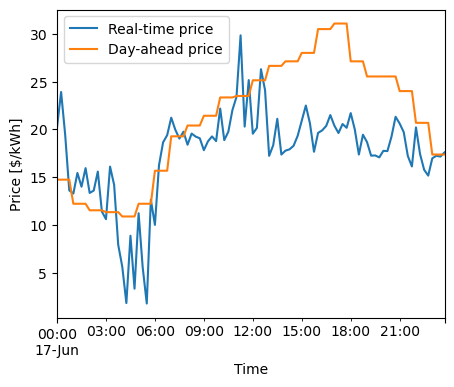

In [20]:
data_plot[['Real-time price', 'Day-ahead price']].plot(xlabel="Time", ylabel="Price [$/kWh]", figsize=(5, 4))

<AxesSubplot:xlabel='Time', ylabel='Price [$/kWh]'>

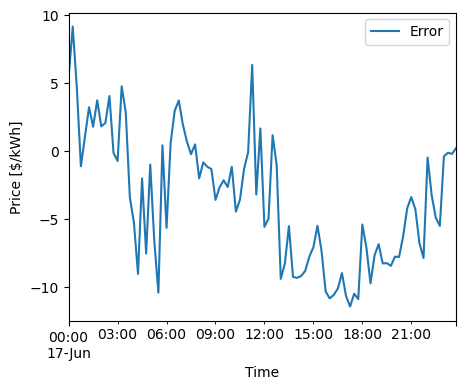

In [21]:
data_plot[['Error']].plot(xlabel="Time", ylabel="Price [$/kWh]", figsize=(5, 4))

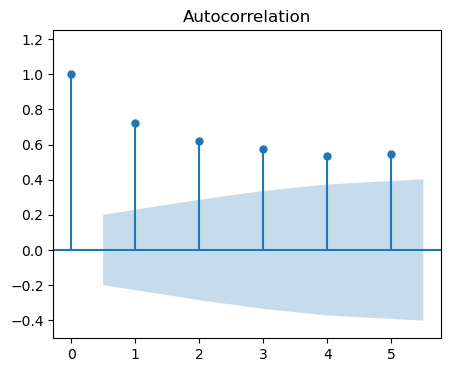

In [24]:
fig, ax = plt.subplots(figsize=(5, 4))
plot_acf(data_plot.Error, lags=5, auto_ylims=True, ax=ax)
plt.show()

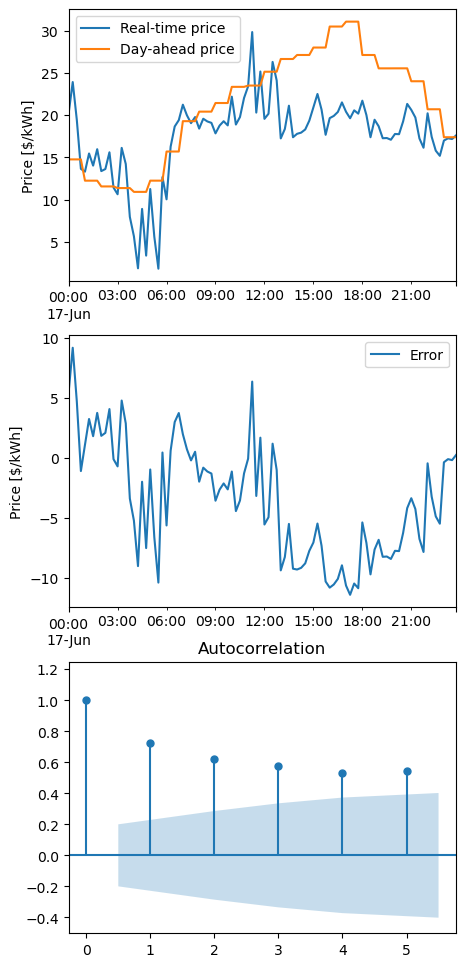

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,12))
data_plot[['Real-time price', 'Day-ahead price']].plot(ax=axes[0], xlabel="", ylabel="Price [$/kWh]")
data_plot[['Error']].plot(ax=axes[1], xlabel="", ylabel="Price [$/kWh]")
#axes[2].acorr(data_plot['Error'], maxlags = 8)
x = plot_acf(data_plot.Error, lags=5, ax=axes[2], auto_ylims=True)

In [8]:
def plot_model(data_plot, path_plot, i):

    fig = go.Figure([
        go.Scatter(
            name='Precio',
            x=data_plot.index,
            y=data_plot.iloc[:,0],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
        ),
        go.Scatter(
            name='Proyección',
            x=data_plot.index,
            y=data_plot['forecast'],
            mode='lines',
            line=dict(color='red'),
        ),
        go.Scatter(
            name='Upper Bound',
            x=data_plot.index,
            y=data_plot['Upper bound'],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=data_plot.index,
            y=data_plot['Lower bound'],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])
    fig.update_layout(
        yaxis_title='Precio ($/kWh)',
        #title='Continuous, variable value error bars',
        hovermode="x"
    )
    fig.write_html(path_plot+str(i)+".html")
    fig.show()
    

In [8]:
def ses_error_model(training_data, alpha, d, plot=False, path_plot=None):

    # Inicializar df con la información
    df = pd.DataFrame()

    # Calcular cantidad de días a pronósticar
    days_forecast = training_data.index[-1]-training_data.index[0]
    days_forecast = days_forecast.days

    for i in tqdm(range(days_forecast)):
        
        # Training set
        day = training_data.index[i*96]
        df_day = training_data.loc[day:day+DateOffset(minutes=95*15),]

        ses = []

        for j in range(96):
            
            forecast_dates=[day + DateOffset(minutes=15*(j-1)) + DateOffset(minutes=15*x) for x in range(1,97-j)]
            df_forecast = df_day.loc[forecast_dates].copy()
    
            # Calcular lags y realizar predicción como el promedio movil de los errores
            if j==0:
                error = 0
            elif j==1:
                error = df_day.loc[forecast_dates[0]-DateOffset(minutes=15), 'e']
                ses.append(error)
            else:
                error = ses[-1] + alpha*(df_day.loc[forecast_dates[0]-DateOffset(minutes=15), 'e']-ses[-1])
                ses.append(error)
            
            decay = np.array([d**x for x in range(len(forecast_dates))])
            df_forecast['e_pred'] = error*decay 

            # Update dataframe
            df_forecast['From'] = day + DateOffset(minutes=15*(j-1))
            df_forecast['Day'] = day
            df = pd.concat([df, df_forecast.reset_index()])

        if plot==True:
            plot_model(df_forecast, path_plot, i)

        #print(str(i)+"|"+str(days_forecast-1),'train:', train.index[0], '->', train.index[-1], '|forecast:', forecast_dates[0], '->', forecast_dates[-1], '|mse:', df_forecast['MSE'].mean())

    #time.sleep(0.1)
    return df

In [33]:
def auto_ses(training_data, alpha_limits, decay_limits, ruta):

    # Crear libro de excel
    book = op.Workbook()
    sheet = book.active
    sheet.title = 'Resultados'
    sheet.cell(3,1).value = 'alpha'
    sheet.cell(3,2).value = 'decay'
    sheet.cell(3,3).value = 'mse_mean'
    sheet.cell(3,4).value = 'mse_sd'

    # Inicializar lista con el mse de cada modelo y el contador
    mse_models = {}
    c = 3
    for alpha in alpha_limits:   
        for d in decay_limits:
                            
            print(" Model:", "({}, {})".format(alpha, d))
            time.sleep(0.1)
            df = ses_error_model(training_data=training_data, alpha=alpha, d=d)
            df['mse'] = (df['e']-df['e_pred'])**2
            mse_mean = df['mse'].mean()
            mse_sd = df['mse'].var()**(1/2)
            mse_models["({}, {})".format(alpha, d)] = mse_mean
            c = c+1
            sheet.cell(c,1).value = alpha
            sheet.cell(c,2).value = d
            sheet.cell(c,3).value = mse_mean
            sheet.cell(c,4).value = mse_sd

            book.save(ruta)

    # best model
    sheet.cell(1,1).value = 'Mejor modelo:'
    sheet.cell(1,2).value = min(mse_models, key=mse_models.get)
    sheet.cell(1,3).value = min(mse_models.values())

    book.save(ruta)
                            

In [34]:
# Parámetros
timesteps = 96
days = 1 # 5 dias de observación
ruta = 'resultados/resultados_rolling_error_ses_decay.xlsx'

alpha_limits = np.arange(0.1, 1, 0.2)
decay_limits = [0.8, 0.9, 0.99, 1]

auto_ses(training_data=training_data, alpha_limits=alpha_limits, decay_limits=decay_limits, ruta=ruta)
    

  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.1, 0.8)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.1, 0.9)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.1, 0.99)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.1, 1)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.30000000000000004, 0.8)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.30000000000000004, 0.9)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.30000000000000004, 0.99)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.30000000000000004, 1)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.5000000000000001, 0.8)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.5000000000000001, 0.9)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.5000000000000001, 0.99)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.5000000000000001, 1)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.7000000000000001, 0.8)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.7000000000000001, 0.9)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.7000000000000001, 0.99)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.7000000000000001, 1)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.9000000000000001, 0.8)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.9000000000000001, 0.9)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.9000000000000001, 0.99)


  0%|          | 0/60 [00:00<?, ?it/s]

 Model: (0.9000000000000001, 1)


100%|██████████| 60/60 [00:30<00:00,  1.98it/s]


In [9]:
# Mejor modelo

# Parámetros
timesteps = 96
days = 1 # 5 dias de observación
path_plot = "resultados/plots/price/hybrid_rolling_error_ma/"
df = ses_error_model(training_data=training_data, alpha=0.1, d=0.99)


100%|██████████| 60/60 [00:22<00:00,  2.65it/s]


In [10]:
df['p_pred'] = df['dayahead']+df['e_pred']
dias = df['Day'].unique()
df['From'] = df['From'].astype(str)
df['mse'] = (df['e']-df['e_pred'])**2
df = df.reset_index(drop=True)
df.head()

,DateTime,p,dayahead,e,e_pred,From,Day,p_pred,mse
0,2019-06-01 00:00:00,17.934000,14.783,3.151000,0.0,2019-05-31 23:45:00,2019-06-01,14.783,9.928801
1,2019-06-01 00:15:00,23.497000,14.783,8.714000,0.0,2019-05-31 23:45:00,2019-06-01,14.783,75.933796
2,2019-06-01 00:30:00,17.564000,14.783,2.781000,0.0,2019-05-31 23:45:00,2019-06-01,14.783,7.733961
3,2019-06-01 00:45:00,13.970667,14.783,-0.812333,0.0,2019-05-31 23:45:00,2019-06-01,14.783,0.659885
4,2019-06-01 01:00:00,23.159667,13.411,9.748667,0.0,2019-05-31 23:45:00,2019-06-01,13.411,95.036502


In [11]:
df[df.From=='2019-06-01 00:15:00']

,DateTime,p,dayahead,e,e_pred,From,Day,p_pred,mse
191,2019-06-01 00:30:00,17.564000,14.783,2.781000,3.707300,2019-06-01 00:15:00,2019-06-01,18.490300,0.858032
192,2019-06-01 00:45:00,13.970667,14.783,-0.812333,3.670227,2019-06-01 00:15:00,2019-06-01,18.453227,20.093347
193,2019-06-01 01:00:00,23.159667,13.411,9.748667,3.633525,2019-06-01 00:15:00,2019-06-01,17.044525,37.394961
194,2019-06-01 01:15:00,19.575000,13.411,6.164000,3.597189,2019-06-01 00:15:00,2019-06-01,17.008189,6.588516
195,2019-06-01 01:30:00,16.764667,13.411,3.353667,3.561218,2019-06-01 00:15:00,2019-06-01,16.972218,0.043077
...,...,...,...,...,...,...,...,...,...
280,2019-06-01 22:45:00,17.843667,15.987,1.856667,1.515619,2019-06-01 00:15:00,2019-06-01,17.502619,0.116313
281,2019-06-01 23:00:00,28.482667,13.821,14.661667,1.500463,2019-06-01 00:15:00,2019-06-01,15.321463,173.217286
282,2019-06-01 23:15:00,21.325000,13.821,7.504000,1.485458,2019-06-01 00:15:00,2019-06-01,15.306458,36.222845
283,2019-06-01 23:30:00,26.808333,13.821,12.987333,1.470604,2019-06-01 00:15:00,2019-06-01,15.291604,132.635063


In [12]:
df["From2"] = "Forecast at " + df["From"].str.slice(start=-8, stop=-3)

In [18]:
colorscale = []
rgb = px.colors.convert_colors_to_same_type(px.colors.sequential.haline)[0]
n_steps = int(np.round(96/(len(rgb)-1)))  # Control the number of colors in the final colorscale
for i in range(len(rgb) - 1):
    for step in np.linspace(0, 1, n_steps):
        colorscale.append(px.colors.find_intermediate_color(rgb[i], rgb[i + 1], step, colortype='rgb'))

for i in range(len(colorscale)):
    colorscale[i] = colorscale[i][:-1]+', 0.5)'
    colorscale[i] = 'rgba'+colorscale[i][3:]

fig = px.line(df[df['Day']==dias[20]], x="DateTime", y="p_pred", color='From2',color_discrete_sequence=colorscale, labels={"From2": ""})

labels_to_show_in_legend = ["Forecast at 0{}:00".format(i) for i in range(0, 10, 2)]+["Forecast at {}:00".format(i) for i in range(10, 24, 2)]

for trace in fig['data']: 
    if (not trace['name'] in labels_to_show_in_legend):
        trace['showlegend'] = False

fig.add_trace(go.Scatter(x=df[(df['Day']==dias[20]) & (df['From']=='2019-06-21 00:00:00')]["DateTime"], 
                         y=df[(df['Day']==dias[20]) & (df['From']=='2019-06-21 00:00:00')]["p"], 
                         name="Actual price",
                         line=dict(color='black'),))
fig.add_trace(go.Scatter(x=df[(df['Day']==dias[20]) & (df['From']=='2019-06-21 00:00:00')]["DateTime"], 
                         y=df[(df['Day']==dias[20]) & (df['From']=='2019-06-21 00:00:00')]["dayahead"], 
                         name="Day-ahead price",
                         line=dict(color='red'),))

fig.update_layout(title_text="Rolling forecast of real-time electricity prices",
                  yaxis=dict(title="Price [cents/kWh]"),
                  xaxis=dict(title= "Time"))

fig.update_layout(title_text="Rolling forecast of real-time electricity prices",
                  yaxis=dict(title="Price [cents/kWh]"),
                  xaxis=dict(title= "Time"))

fig.write_image("../../Soportes documento/Graficas documento/price_forecast.png", scale=2, height = 450, width=700)
fig.show()